In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization

In [2]:
import os
os.listdir("C:/Users/HTCM/Jupyter/Stomata(MM)/training/stomata_AI/train")

['kadam_shade', 'kadam_sun', 'Mahagoni_shade', 'Mahagoni_sun']

In [3]:
EPOCHS = 5
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((300,225))
image_size = 0
directory_root = 'C:/Users/HTCM/Jupyter/Stomata(MM)/training/stomata_AI'
width=300
height=225
depth=3

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing kadam_shade ...
[INFO] Processing kadam_sun ...
[INFO] Processing Mahagoni_shade ...
[INFO] Processing Mahagoni_sun ...
[INFO] Processing kadam_shade ...
[INFO] Processing kadam_sun ...
[INFO] Processing Mahagoni_shade ...
[INFO] Processing Mahagoni_sun ...
[INFO] Image loading completed


In [5]:
image_size = len(image_list)
image_size

132

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Mahagoni_shade' 'Mahagoni_sun' 'kadam_shade' 'kadam_sun']


# **Normalization Of images**

In [7]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


# **Augmentation Of data**

In [8]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# ***5 Layer CNN Algorithm ***

In [32]:

model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 225, 300, 32)      896       
_________________________________________________________________
activation_2 (Activation)    (None, 225, 300, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 225, 300, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 100, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 100, 32)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 100, 64)       18496     
_________________________________________________________________
activation_3 (Activation)    (None, 75, 100, 64)      

# **Optimizer**

In [33]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [35]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=5, verbose=1
    )

Epoch 1/5
3/3 [==============================] - 20s 6s/step - loss: 0.5454 - accuracy: 0.7188 - val_loss: 2.4014 - val_accuracy: 0.2963
Epoch 2/5
3/3 [==============================] - 16s 5s/step - loss: 0.5263 - accuracy: 0.6438 - val_loss: 2.2946 - val_accuracy: 0.2963
Epoch 3/5
3/3 [==============================] - 17s 7s/step - loss: 0.8308 - accuracy: 0.5205 - val_loss: 1.9326 - val_accuracy: 0.2963
Epoch 4/5
3/3 [==============================] - 15s 5s/step - loss: 0.7077 - accuracy: 0.5616 - val_loss: 1.7064 - val_accuracy: 0.2963
Epoch 5/5
3/3 [==============================] - 14s 4s/step - loss: 0.5292 - accuracy: 0.6986 - val_loss: 1.2255 - val_accuracy: 0.3333


# **Results and Plots**

In [36]:
def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    #Train and validation accuracy
    plt.plot(epochs, acc, 'b', label='Training accurarcy')
    plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    plt.figure()
    #Train and validation loss
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(x_test, y_test)
    print(f"Test Accuracy: {scores[1]*100}")
    
    #print("[INFO] Saving model")
    #model.save(name)
    

[INFO] Plotting model accuracy and Loss


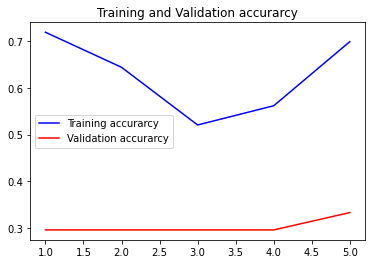

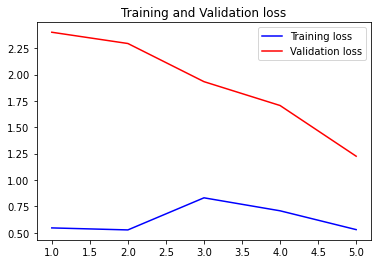

[INFO] Calculating model accuracy
1/1 [==============================] - 1s 842ms/step - loss: 1.2255 - accuracy: 0.3333
Test Accuracy: 33.33333432674408


In [37]:
Res_Plot_Test_Save('penta_CNN_Algorithm.h5')

# Resnet Model
Weights : Imagenet

In [14]:
# !pip install keras_applications==1.0.4 --no-deps
# !pip install keras_preprocessing==1.0.2 --no-deps
# !pip install h5py==2.8.0
# !pip install resnet

In [15]:

import keras
from keras.models import Model
from keras import applications
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
from keras.applications import resnet50

# Get the Resnet model so we can do transfer learning
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (128,128,3))
                             
# Add a global spatial average pooling layer
out = base_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_model.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) 
model.summary()

ImportError: cannot import name 'resnet50' from 'keras.applications' (C:\ProgramData\Anaconda3\lib\site-packages\keras\applications\__init__.py)